
This is variational auto-encoder (VAE) implementation using tensorflow of the following non-linear latent variable model with one latent variable:

\begin{align*}
    Z &\sim N(0, 1)\\
    X_j | Z &= g_j(Z) + \epsilon_j\\
    \epsilon_j &\sim N(0, \sigma_j^2), \quad j=1, \dots, p
\end{align*}

This model can be likened to a non-linar factor analysis model, or, with the assumption that $\sigma_j = \sigma \quad \forall j$, to a one-dimensional non-linear probabilistic principal component analysis (PPCA) model. 


Given some observed data $\{X^{(i)}\}_{i=1}^n$ with $X^{(i)} \in \mathbb R^p$, the goal is to estimate the functions $g_j: \mathbb R \to \mathbb R$.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Load data
We load a toy dataset with dimensions $n=100, p=100$.

In [2]:
data = pd.read_csv("./data/q1/data_1_200_100_1.csv")
data = np.array(data, dtype='float32')
data = np.expand_dims(data, axis=-1)
data_train = data[:int(data.shape[0]*.9)]
data_test  = data[int(data.shape[0]*.9):]

In [3]:
data_train.shape

(180, 100, 1)

## Create the sampling layer

In [4]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Create the encoder
The encoder encodes the observed variables into the parameters of the posterior distribution of $Z^{(i)}|Y^{(i)}$. Both the mean and variance share the first layer.

In [5]:
latent_dim = 1

encoder_inputs = keras.Input(shape=data_train.shape[1:])
x = layers.Flatten()(encoder_inputs)
x = layers.Dense(100, activation="relu")(x)
z_mean = layers.Dense(100, activation="relu")(x)
z_mean = layers.Dense(100, activation="relu")(x)
z_mean =layers.Dense(latent_dim, name="z_mean", activation="linear")(z_mean)

z_log_var = layers.Dense(100, activation="relu")(x)
z_log_var = layers.Dense(100, activation="relu")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var", activation="linear")(z_log_var)
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 1)]     0           []                               
                                                                                                  
 flatten (Flatten)              (None, 100)          0           ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 100)          10100       ['flatten[0][0]']                
                                                                                                  
 dense_2 (Dense)                (None, 100)          10100       ['dense[0][0]']                  
                                                                                            

## Create the Decoder
The decoder has to be flexible enough to be able to model the functions $g_j$, which models the conditional means of the responses. On top of that, the decoder models the residual variances $\sigma_j$. 

In [6]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(50, activation="relu")(latent_inputs)
x = layers.Dense(100, activation="relu")(x)

log_var = layers.Dense(100, activation="relu")(x)
log_var = layers.Dense(100, activation="linear")(log_var)
log_var = layers.Reshape(data_train.shape[1:])(log_var)


x_output = layers.Dense(100, activation="relu")(x)
x_output = layers.Dense(100, activation="linear")(x_output)
x_output = layers.Reshape(data_train.shape[1:])(x_output)

decoder = keras.Model(latent_inputs, [x_output, log_var], name="decoder")
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_5 (Dense)                (None, 50)           100         ['input_2[0][0]']                
                                                                                                  
 dense_6 (Dense)                (None, 100)          5100        ['dense_5[0][0]']                
                                                                                                  
 dense_9 (Dense)                (None, 100)          10100       ['dense_6[0][0]']                
                                                                                            

## Create the variational autoencoder

The variational auto-encoder (VAE) is itself a `keras.Model` object. It consists of the `encoder` and `decoder` layers, a specialized `train_step` as well of some specialized `metrics` to keep track of our progress.

In [7]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction, logvar = self.decoder(z)
            logvar = tf.reduce_mean(logvar, axis=1, keepdims=True)

            # Reconstruction loss (including the residual variances)
            reconstruction_loss = 0.5 * tf.reduce_mean(tf.reduce_sum((data - reconstruction)**2 * tf.math.exp(-logvar) + logvar + tf.math.log(2. * np.pi), axis=1))

            # ELBO loss, approximating the posterior with a Gaussian.
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

Now Markdown

In [8]:
#| output: false
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(data_train, epochs=200)

Epoch 1/200
6/6 [==============================] - 5s 5ms/step - total_loss: 159.4694 - reconstruction_loss: 158.8095 - kl_loss: 0.6599
Epoch 2/200
6/6 [==============================] - 0s 6ms/step - total_loss: 157.3188 - reconstruction_loss: 156.3394 - kl_loss: 0.9794
Epoch 3/200
6/6 [==============================] - 0s 6ms/step - total_loss: 154.5943 - reconstruction_loss: 153.0545 - kl_loss: 1.5398
Epoch 4/200
6/6 [==============================] - 0s 6ms/step - total_loss: 152.1033 - reconstruction_loss: 150.5485 - kl_loss: 1.5548
Epoch 5/200
6/6 [==============================] - 0s 6ms/step - total_loss: 147.7574 - reconstruction_loss: 144.8417 - kl_loss: 2.9157
Epoch 6/200
6/6 [==============================] - 0s 7ms/step - total_loss: 142.2038 - reconstruction_loss: 138.8096 - kl_loss: 3.3943
Epoch 7/200
6/6 [==============================] - 0s 7ms/step - total_loss: 136.3394 - reconstruction_loss: 133.4327 - kl_loss: 2.9067
Epoch 8/200
6/6 [==============================]

## Plot
We now plot the fit, i.e. the reconstruction vs the original data.

6/6 [==============================] - 0s 2ms/step


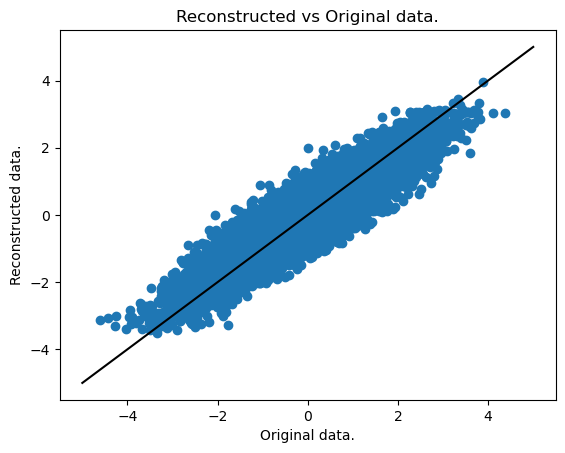

In [9]:
encoded, _, _ = vae.encoder.predict(data_train)
decoded, var = vae.decoder.predict(encoded)

f, ax = plt.subplots()
ax.scatter(
    data_train.reshape((np.prod(decoded.shape),)),
    decoded.reshape((np.prod(decoded.shape),))
)
ax.plot([-5,5], [-5,5], 'k-')
plt.title("Reconstructed vs Original data.")
plt.xlabel("Original data.")
plt.ylabel("Reconstructed data.")
plt.show()

We can also plot the estimated latent variables (the encoded data), which should approximately be standard normal random variables.

Text(0, 0.5, 'Frequency')

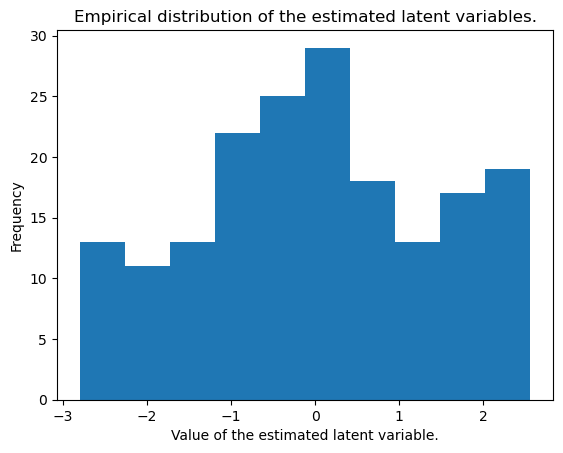

In [10]:
plt.hist(encoded)
plt.title("Empirical distribution of the estimated latent variables.")
plt.xlabel("Value of the estimated latent variable.")
plt.ylabel("Frequency")


Finally, we can also plot a selection of the $g_j$ functions.

2/2 [==============================] - 0s 5ms/step


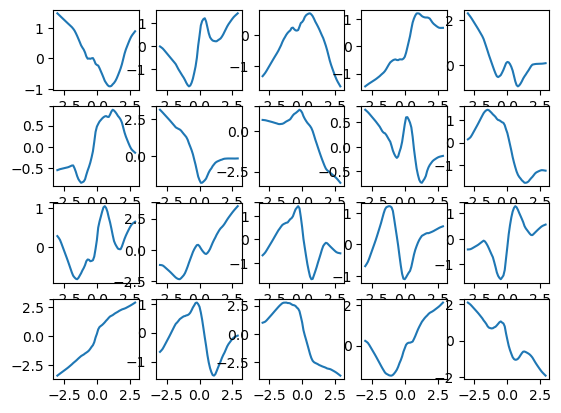

In [11]:
# Define a range of values to plot
z_grid = np.arange(-3,3, .1)
z_grid = np.expand_dims(z_grid, axis=1)

# Obtain the map of these values through the estimated g_j functions
y_grid, _ = vae.decoder.predict(z_grid)

# Plot 20 of these
n = 20
plt.figure()
for i in range(n):
    plt.subplot(4,int(n/4),i+1)
    plt.plot(z_grid[:,-1], y_grid[:,i, -1])